# Problem #1: Modelling Snakes and Ladders:

Model the game of Snakes and Ladders (single-player game) as a Markov Process. Write out it’s
state space and structure of transition probabilities.

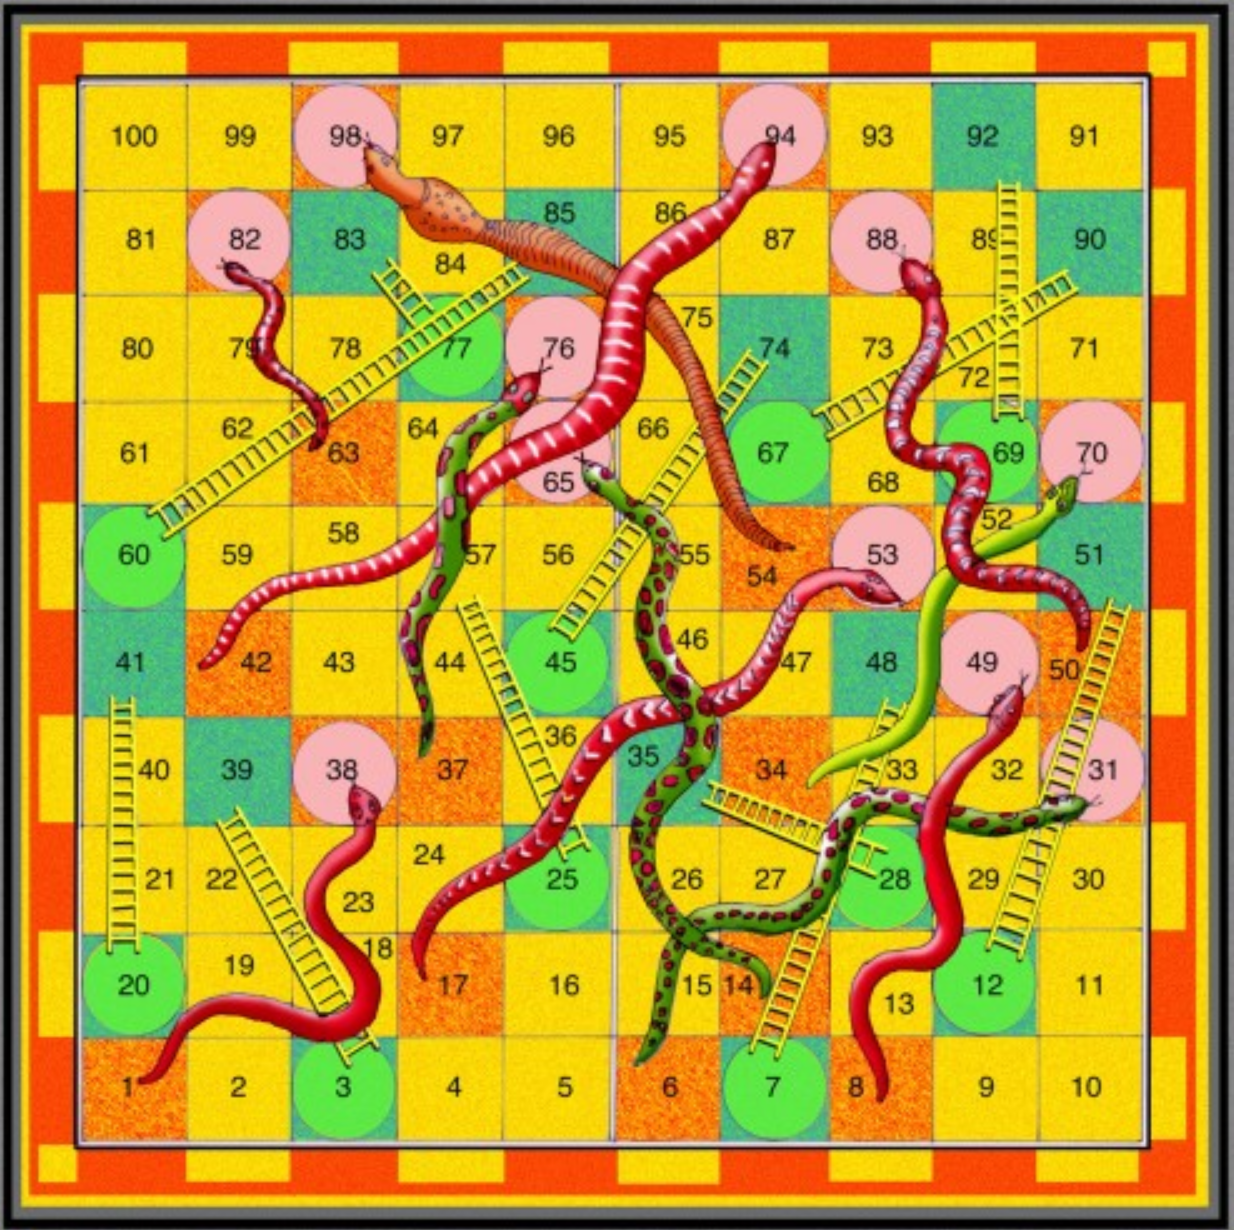

**Solution:** The first thing to remember is that since Snakes & Ladders is a game, it has to end, and therefore this is a finite markov process. 

$\mathcal{S} =$ State Space of the Snakes & Ladders game. Each of the different spaces that a player can be on represent the state space with the starting space being the starting state: $\mathcal{S}_0$ 

The probability of moving to another state (another space) is determined by a dice roll and so it is 1 in 6 for the subsequent spaces that a player is on. for example if I am starting off on space 0, I can roll a 1,2,3,4,5,6 each with a probability of 1/6. I also need to notice that if I roll a 3 then I will be moved up to space 39. Using a transition map allows us to relate the movements to possible dice rolls. 

**State Space:**

Let N = the number of spaces on the board. 

$\mathcal{S} = \{0,N\}$

$\mathcal{S}_0 = [0]$

$\mathcal{T} = [N]$

$\mathcal{N} = [0,N-1]$

**Structure of Transition Probabilities:**

We could set up the transition probabilities of any state becoming another state by creating a 2D array where one dimension represents the starting state and the other dimension represents the state that would be transitioned to in the next timestep. Then the values across the array would represent the probability $[0 \to 1]$ of that event happening. This formalism would look like

\begin{equation}
\mathcal{P} : \mathcal{N} \times \mathcal{S} \to [0,1]
\end{equation}

<font color='red'>
<font color='black'>

However, as the book goes into detail (pg 49) there is a better way of mapping the transition probabilities this is represented by the equivalent curried form and only takes in a single space and returns the distribution of possible states. 
    
\begin{equation}
\mathcal{P} : \mathcal{N} \to \left(\mathcal{S} \to [0,1] \right)
\end{equation}
    
The first $\to$ represents a map from $\mathcal{N}$ to $\mathcal{S}$. Effectively, for each of the states that can transition $\mathcal{N}$, return the possible states that have non zero transition probabilites and also return what those transition probabilities are. 

# Problem #2: Create a transition map

Create a transition map: Transition data structure to represent the transition probabilities of the
Snakes and Ladders Markov Process so you can model the game as an instance of FiniteMarkovProcess.
Use the method traces to create sampling traces. Plot a graph of the probability distribution of
time steps to finish the game.

### Building the Snakes & Ladders Maps:

1. Define a 0 $\to$ N 1D array that represents the total number of spaces
2. Define a dictionary of Snakes that link the start of the snake to its end {8:4,12:6,....}
3. Define a dictionary of Ladders that link the start of a ladder to its end {1:23,5:12,...}
4. Create a function that turns these 3 parameters into a transition map.
5. Optional: make a dice class that defines what dice rolls can happen and with what probabilities

In [146]:
import sys
sys.path.append("../../RL-book")
from rl import markov_process
from dataclasses import dataclass
from typing import Mapping, Dict
from rl.distribution import Categorical
from rl.markov_process import Transition, FiniteMarkovProcess
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt

### Creating a Class for the game state:

In [147]:
#Step 1: Create a class to represent the state that the game is in:
@dataclass(frozen=True)
class SNL_Game_State:
    '''This class represents the state of the game. It is a normal class so we can make an instance of it
    We cant update the game state attribute position since the class is frozen. This means that we have to
    make a new class for each of the states that we traverse into. This is the correct way to make
    start a continuous markov process. As the process continues we can just create a new state
    with a new (position) whenever we need to change states or until we
    hit a terminal state.'''
    
    position: int
        
#Testing
S = SNL_Game_State(position=0)
print ("Assign: ",S.position)
 

Assign:  0


#### Question:

Why do we want the State to be frozen? Doesn't it make more sense to build a state that can be updated? The whole point of a markov process is that the next state depends on the current state only, so don't we have all the information in the current state to just update it? What is the logic behind this?

#### Answer:

The states need to be hashable and they will not be if they can change value


In [148]:
#Update state should give error since it is frozen:

#S.position = 1

In [149]:
#We can make a state class that is updatable if we don't want to create a new instance each time
@dataclass(frozen=False)
class SNL_Game_State_Updatable:
    '''This class is the same as the one above but has the ability to update the position'''
    position: int
        
#Testing
S = SNL_Game_State_Updatable(position=0)
print ("Assign: ", S.position)

#Upaate:
S.position = 1
print ("Update: ",S.position)

Assign:  0
Update:  1


### Create class to represent finite markov process of playing snakes and ladders:

In [150]:
#Step 2: Create a class to represent the process that inherits the FiniteMarkovProperty Class
class SNL_MPFinite(FiniteMarkovProcess[SNL_Game_State]):
    '''
    '''
    def __init__(
        self,
        board_size: int,
        snakes: dict,
        ladders: dict
    ):
        self.snakes = snakes
        self.ladders = ladders
        self.board_size = board_size
        
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> Transition[SNL_Game_State]:
        d: Dict[SNL_Game_State, Categorical[SNL_Game_State]] = {}
        
        for i in range(0,self.board_size):
            temp_dict= {}

            #Figure out the possible state that you can go to.
            if i >= self.board_size-5:
                m = self.board_size - i+1
            else:
                m = 7
            Possible_States_int = np.fromiter((i+j for j in range(1,m)),int)
            #Creates an array of int that represent the position value of the next states

            #Replace States to account for the Snakes and Ladder:
            for j,state_int in enumerate(Possible_States_int):
                if state_int in self.snakes.keys():
                    Possible_States_int[j] = self.snakes[state_int]
                elif state_int in self.ladders.keys():
                    Possible_States_int[j] = self.ladders[state_int]
                                    
                #Convert integer into a game state with position as int:
                Game_State = SNL_Game_State(position=Possible_States_int[j])
                
                temp_dict[Game_State]= 1/6
            
            d[SNL_Game_State(position=i)] = Categorical(temp_dict)
        d[SNL_Game_State(position=self.board_size)] = None
        return d
    

### Generateing Transition Map:

In [151]:
#Testing out the get_transition_map function:

if __name__ =='__main__':
    board_size = 100
    snakes = {98:54,94:42,88:50,82:63,76:37,70:34,65:14,53:17,49:8,38:1,31:6}
    ladders = {3:39,7:48,12:51,20:41,25:57,28:35,45:74,60:85,67:90,69:92,77:83}
    
    SNL_markov_process = SNL_MPFinite(board_size=board_size,snakes=snakes,ladders=ladders)
    
    print("Transition Map")
    print("--------------")
    print(SNL_markov_process.get_transition_map())

Transition Map
--------------
{SNL_Game_State(position=0): {SNL_Game_State(position=1): 0.16666666666666669, SNL_Game_State(position=2): 0.16666666666666669, SNL_Game_State(position=39): 0.16666666666666669, SNL_Game_State(position=4): 0.16666666666666669, SNL_Game_State(position=5): 0.16666666666666669, SNL_Game_State(position=6): 0.16666666666666669}, SNL_Game_State(position=1): {SNL_Game_State(position=2): 0.16666666666666669, SNL_Game_State(position=39): 0.16666666666666669, SNL_Game_State(position=4): 0.16666666666666669, SNL_Game_State(position=5): 0.16666666666666669, SNL_Game_State(position=6): 0.16666666666666669, SNL_Game_State(position=48): 0.16666666666666669}, SNL_Game_State(position=2): {SNL_Game_State(position=39): 0.16666666666666669, SNL_Game_State(position=4): 0.16666666666666669, SNL_Game_State(position=5): 0.16666666666666669, SNL_Game_State(position=6): 0.16666666666666669, SNL_Game_State(position=48): 0.16666666666666669, SNL_Game_State(position=8): 0.166666666666

### Simulated Games:

In [152]:
start_distribution = Categorical({SNL_Game_State(position=0):1})

for i, trace in enumerate(SNL_markov_process.traces(start_distribution)):
    if i >= 1:
        break
    print ("New Trace")
    for j,x in enumerate(trace):
        pass
        print ("Dice Roll:",j,x)
    print ("")
    print ("Total # of Rolls",j)

New Trace
Dice Roll: 0 SNL_Game_State(position=0)
Dice Roll: 1 SNL_Game_State(position=39)
Dice Roll: 2 SNL_Game_State(position=43)
Dice Roll: 3 SNL_Game_State(position=74)
Dice Roll: 4 SNL_Game_State(position=75)
Dice Roll: 5 SNL_Game_State(position=79)
Dice Roll: 6 SNL_Game_State(position=84)
Dice Roll: 7 SNL_Game_State(position=89)
Dice Roll: 8 SNL_Game_State(position=93)
Dice Roll: 9 SNL_Game_State(position=54)
Dice Roll: 10 SNL_Game_State(position=85)
Dice Roll: 11 SNL_Game_State(position=89)
Dice Roll: 12 SNL_Game_State(position=95)
Dice Roll: 13 SNL_Game_State(position=99)
Dice Roll: 14 SNL_Game_State(position=100)

Total # of Rolls 14


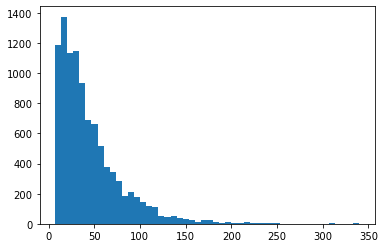

In [153]:

start_distribution = Categorical({SNL_Game_State(position=0):1})

games = 10000
rolls = []
for i, trace in enumerate(SNL_markov_process.traces(start_distribution)):
    if i >= games:
        break
    #print ("New Trace")
    for j,x in enumerate(trace):
        pass
        #print ("Dice Roll:",j,x)
    #print ("Total # of Rolls",j)
    rolls.append(j)
    
plt.hist(rolls, bins = 50)
plt.show()

    
    
    
    

    
            
        

### Testing out terminal state:

In [154]:
#Testing out terminal states:
SNL_markov_process.is_terminal(state=SNL_Game_State(position=99))

False

In [155]:
Traces = SNL_markov_process.traces([SNL_Game_State(position=0)])
print (Traces)

<generator object MarkovProcess.traces at 0x00000265ACE7A8C8>


In [156]:
def simulation(process, start_state):
    state = start_state
    while True:
        yield state
        state = process.next_state(state)
        
simulation(SNL_markov_process,SNL_Game_State(position=0))

<generator object simulation at 0x00000265ACE623C8>

In [157]:
#Function to generate the transition map:
import numpy as np
#Create Snakes And Ladders Game in Picture:
N = 10
Snakes = {98:54,94:42,88:50,82:63,76:37,70:34,65:14,53:17,49:8,38:1,31:6}
Ladders = {3:39,7:48,12:51,20:41,25:57,28:35,45:74,60:85,67:90,69:92,77:83}


#Create Dictionary of Dictionaries for possible transitions:
Transition_test = {}
dice_roll_prob = 1/6
for i in range(0,N):
    temp_dict= {}
    
    #Figure out the possible state that you can go to.
    if i >= N-5:
        m = N - i+1
    else:
        m = 7
    Possible_States = np.fromiter((i+j for j in range(1,m)),float)
    
    #Replace States to account for the Snakes and Ladder:
    for j,state in enumerate(Possible_States):
        if state in Snakes.keys():
            Possible_States[j] = Snakes[state]
        elif state in Ladders.keys():
            Possible_States[j] = Ladders[state]
    
        temp_dict[Possible_States[j]]=dice_roll_prob 
    
    
    Transition_test[i] = temp_dict
    
for t in Transition_test:
    print (Transition_test[t])

{1.0: 0.16666666666666666, 2.0: 0.16666666666666666, 39.0: 0.16666666666666666, 4.0: 0.16666666666666666, 5.0: 0.16666666666666666, 6.0: 0.16666666666666666}
{2.0: 0.16666666666666666, 39.0: 0.16666666666666666, 4.0: 0.16666666666666666, 5.0: 0.16666666666666666, 6.0: 0.16666666666666666, 48.0: 0.16666666666666666}
{39.0: 0.16666666666666666, 4.0: 0.16666666666666666, 5.0: 0.16666666666666666, 6.0: 0.16666666666666666, 48.0: 0.16666666666666666, 8.0: 0.16666666666666666}
{4.0: 0.16666666666666666, 5.0: 0.16666666666666666, 6.0: 0.16666666666666666, 48.0: 0.16666666666666666, 8.0: 0.16666666666666666, 9.0: 0.16666666666666666}
{5.0: 0.16666666666666666, 6.0: 0.16666666666666666, 48.0: 0.16666666666666666, 8.0: 0.16666666666666666, 9.0: 0.16666666666666666, 10.0: 0.16666666666666666}
{6.0: 0.16666666666666666, 48.0: 0.16666666666666666, 8.0: 0.16666666666666666, 9.0: 0.16666666666666666, 10.0: 0.16666666666666666}
{48.0: 0.16666666666666666, 8.0: 0.16666666666666666, 9.0: 0.1666666666666

# Problem #3: Frog Problem

Collaborated with Joe Wakim

**Goal:** determine the expected number of jumps to cross the river

Define the states as steps to cross the river as S

Define step to cross river as N

$\mathcal{S} \in [0,N]$

$\mathcal{T} \in [0]$

$\mathcal{N} \in [1,N]$

Starting state:

$\mathcal{S}_0 = \mathcal{N}$


### Create a State for the position of the frog:

In [158]:
#Step 1: Create a class to represent the state that represents the frogs possitionn:
@dataclass(frozen=True)
class Frog_State:
    '''This class is the state at which the frog is at. It is measured by how many different jumps the frog can take if the
    remaining pads == 0 then the frog has crossed the river. Thus remaining_pads = 0 is the terminal state for this system'''
    
    remaining_pads: int
        
#Testing
S = Frog_State(remaining_pads=10)
print ("Assign: ",S.remaining_pads, "Possible Jumps")

Assign:  10 Possible Jumps


### Create a Finite Markov Process to simulate the process:

In [159]:
Transition

typing.Mapping[~S, typing.Union[rl.distribution.FiniteDistribution[~S], NoneType]]

In [160]:
#Step 2: Create a class to represent the process that inherits the FiniteMarkovProperty Class
class Frog_MPFinite(FiniteMarkovProcess[Frog_State]):
    '''
    This class...
    '''
    def __init__(self, num_possible_jumps: int):
        
        self.num_possible_jumps = num_possible_jumps
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> Transition[Frog_State]:
        d: Dict[Frog_State, Categorical[Frog_State]] = {}
        for i in range(1,self.num_possible_jumps+1):
            temp_dict= {}
            
            possible_states_int = np.arange(0,i)
            jump_probability = 1/i
            
            for j,state in enumerate(possible_states_int):
                State = Frog_State(state)
                temp_dict[State] = jump_probability
    
            
            d[Frog_State(i)] = Categorical(temp_dict)
        d[Frog_State(0)] = None
        return d

### Check Transition Map:

In [161]:
frog_jump = Frog_MPFinite(num_possible_jumps=10)
frog_jump.get_transition_map()

{Frog_State(remaining_pads=1): {Frog_State(remaining_pads=0): 1.0},
 Frog_State(remaining_pads=2): {Frog_State(remaining_pads=0): 0.5, Frog_State(remaining_pads=1): 0.5},
 Frog_State(remaining_pads=3): {Frog_State(remaining_pads=0): 0.3333333333333333, Frog_State(remaining_pads=1): 0.3333333333333333, Frog_State(remaining_pads=2): 0.3333333333333333},
 Frog_State(remaining_pads=4): {Frog_State(remaining_pads=0): 0.25, Frog_State(remaining_pads=1): 0.25, Frog_State(remaining_pads=2): 0.25, Frog_State(remaining_pads=3): 0.25},
 Frog_State(remaining_pads=5): {Frog_State(remaining_pads=0): 0.2, Frog_State(remaining_pads=1): 0.2, Frog_State(remaining_pads=2): 0.2, Frog_State(remaining_pads=3): 0.2, Frog_State(remaining_pads=4): 0.2},
 Frog_State(remaining_pads=6): {Frog_State(remaining_pads=0): 0.16666666666666669, Frog_State(remaining_pads=1): 0.16666666666666669, Frog_State(remaining_pads=2): 0.16666666666666669, Frog_State(remaining_pads=3): 0.16666666666666669, Frog_State(remaining_pads

### Simulate the Markov Frog jumping Process:

In [162]:
start_distribution = Categorical({Frog_State(remaining_pads=10):1})

for i, trace in enumerate(frog_jump.traces(start_state_distribution=start_distribution)):
    if i >= 1:
        break
    print ("New Trace")
    for j,x in enumerate(trace):
        pass
        print ("Jump:",j,x)
    print ("")
    print ("Total # of Jumps",j)

New Trace
Jump: 0 Frog_State(remaining_pads=10)
Jump: 1 Frog_State(remaining_pads=4)
Jump: 2 Frog_State(remaining_pads=1)
Jump: 3 Frog_State(remaining_pads=0)

Total # of Jumps 3


### Create a Markov Reward Process Class so we can solve for the Expected number of jumps:

In [163]:
class Frog_MRPFinite(FiniteMarkovRewardProcess[Frog_State]):
    '''
    This class...
    '''
    def __init__(self, num_possible_jumps: int):
        
        self.num_possible_jumps = num_possible_jumps
        super().__init__(self.get_transition_reward_map())

    def get_transition_reward_map(self) -> RewardTransition[Frog_State]:
        d: Dict[Frog_State, Categorical[Tuple[Frog_State,float]]] = {}
        for i in range(1,self.num_possible_jumps+1):
            temp_dict= {}
            
            possible_states_int = np.arange(0,i)
            jump_probability = 1/i
            
            for j,state in enumerate(possible_states_int):
                State = (Frog_State(state),1)
                temp_dict[State] = jump_probability
    
            
            d[Frog_State(i)] = Categorical(temp_dict)
        d[Frog_State(0)] = None
        return d

In [169]:
frog_jump_reward = Frog_MRPFinite(num_possible_jumps=15)

In [170]:
frog_jump_reward.display_value_function(1)

{Frog_State(remaining_pads=15): 3.318,
 Frog_State(remaining_pads=14): 3.252,
 Frog_State(remaining_pads=11): 3.02,
 Frog_State(remaining_pads=13): 3.18,
 Frog_State(remaining_pads=10): 2.929,
 Frog_State(remaining_pads=7): 2.593,
 Frog_State(remaining_pads=8): 2.718,
 Frog_State(remaining_pads=9): 2.829,
 Frog_State(remaining_pads=1): 1.0,
 Frog_State(remaining_pads=12): 3.103,
 Frog_State(remaining_pads=6): 2.45,
 Frog_State(remaining_pads=3): 1.833,
 Frog_State(remaining_pads=2): 1.5,
 Frog_State(remaining_pads=4): 2.083,
 Frog_State(remaining_pads=5): 2.283}


# Problem #4:

We now want to use an MRP to determine the expected number of dice rolls to finish the game. This means that we need to be able to calculate the value function for all of the steps. Ultimately we only care about the value function for the starting state since we want to know the average number of steps, but we will need to still calculate the value function for the whole thing.

1. Create a class for the State (Done)
2. Create a Finite Markov Process Class that has the get_transition_map function filled out by me (Done)
3. Create a Finite Markov Reward Process class with a get_transition_reward_map. 

In [166]:
#Step 2: Create a class to represent the process that inherits the FiniteMarkovProperty Class
from rl.markov_process import RewardTransition, FiniteMarkovRewardProcess
class SNL_MRP_Finite(FiniteMarkovRewardProcess[SNL_Game_State]):
    '''
    '''
    def __init__(
        self,
        board_size: int,
        snakes: dict,
        ladders: dict
    ):
        self.snakes = snakes
        self.ladders = ladders
        self.board_size = board_size
        
        super().__init__(self.get_transition_reward_map())

    def get_transition_reward_map(self) -> RewardTransition[SNL_Game_State]:
        d: Dict[SNL_Game_State, Categorical[Tuple[SNL_Game_State,float]]] = {}
        
        for i in range(0,self.board_size):
            temp_dict= {}

            #Figure out the possible state that you can go to.
            if i >= self.board_size-5:
                m = self.board_size - i+1
            else:
                m = 7
            Possible_States_int = np.fromiter((i+j for j in range(1,m)),int)
            #Creates an array of int that represent the position value of the next states

            #Replace States to account for the Snakes and Ladder:
            for j,state_int in enumerate(Possible_States_int):
                if state_int in self.snakes.keys():
                    Possible_States_int[j] = self.snakes[state_int]
                elif state_int in self.ladders.keys():
                    Possible_States_int[j] = self.ladders[state_int]
                                    
                #Convert integer into a game state with position as int:
                Game_State = (SNL_Game_State(position=Possible_States_int[j]),1) #Assign Reward of 1
                
                temp_dict[Game_State]= 1/6
            
            d[SNL_Game_State(position=i)] = Categorical(temp_dict)
        d[SNL_Game_State(position=self.board_size)] = None
        return d

In [171]:
board_size = 100
snakes = {98:54,94:42,88:50,82:63,76:37,70:34,65:14,53:17,49:8,38:1,31:6}
ladders = {3:39,7:48,12:51,20:41,25:57,28:35,45:74,60:85,67:90,69:92,77:83}

SNL_MRP = SNL_MRP_Finite(board_size=board_size,snakes=snakes,ladders=ladders)
SNL_MRP.get_transition_reward_map()

{SNL_Game_State(position=0): {(SNL_Game_State(position=1), 1): 0.16666666666666669, (SNL_Game_State(position=2), 1): 0.16666666666666669, (SNL_Game_State(position=39), 1): 0.16666666666666669, (SNL_Game_State(position=4), 1): 0.16666666666666669, (SNL_Game_State(position=5), 1): 0.16666666666666669, (SNL_Game_State(position=6), 1): 0.16666666666666669},
 SNL_Game_State(position=1): {(SNL_Game_State(position=2), 1): 0.16666666666666669, (SNL_Game_State(position=39), 1): 0.16666666666666669, (SNL_Game_State(position=4), 1): 0.16666666666666669, (SNL_Game_State(position=5), 1): 0.16666666666666669, (SNL_Game_State(position=6), 1): 0.16666666666666669, (SNL_Game_State(position=48), 1): 0.16666666666666669},
 SNL_Game_State(position=2): {(SNL_Game_State(position=39), 1): 0.16666666666666669, (SNL_Game_State(position=4), 1): 0.16666666666666669, (SNL_Game_State(position=5), 1): 0.16666666666666669, (SNL_Game_State(position=6), 1): 0.16666666666666669, (SNL_Game_State(position=48), 1): 0.1666

In [168]:
SNL_MRP.display_value_function(gamma=1)

{SNL_Game_State(position=23): 44.358,
 SNL_Game_State(position=18): 44.71,
 SNL_Game_State(position=19): 43.374,
 SNL_Game_State(position=29): 45.349,
 SNL_Game_State(position=30): 45.06,
 SNL_Game_State(position=31): 44.876,
 SNL_Game_State(position=32): 44.847,
 SNL_Game_State(position=33): 44.369,
 SNL_Game_State(position=34): 43.961,
 SNL_Game_State(position=24): 44.458,
 SNL_Game_State(position=13): 45.601,
 SNL_Game_State(position=12): 45.972,
 SNL_Game_State(position=14): 45.028,
 SNL_Game_State(position=35): 43.623,
 SNL_Game_State(position=36): 43.323,
 SNL_Game_State(position=37): 43.136,
 SNL_Game_State(position=38): 42.622,
 SNL_Game_State(position=39): 41.502,
 SNL_Game_State(position=40): 41.515,
 SNL_Game_State(position=41): 41.591,
 SNL_Game_State(position=42): 41.523,
 SNL_Game_State(position=43): 42.018,
 SNL_Game_State(position=44): 41.582,
 SNL_Game_State(position=45): 42.194,
 SNL_Game_State(position=46): 41.597,
 SNL_Game_State(position=47): 42.047,
 SNL_Game_Stat

Answer = 46 rolls